In [16]:
import numpy as np
import cmdstanpy
import matplotlib.pyplot as plt

def simulate_regions(n_timesteps: int, n_regions: int) -> np.ndarray:
    rng = np.random.RandomState(0)
    time = np.arange(n_timesteps)
    rfx_int = rng.normal(loc=0, scale=0.2, size=n_regions)
    rfx_slope = rng.normal(loc=0, scale=0.2, size=n_regions)

    expectation = np.exp(
        (0.5 + rfx_slope) * np.sin(2 * np.pi * time.reshape(-1, 1) / 7) + 2.5 + rfx_int
    )

    return expectation


def create_counterfactuals(expectation: np.ndarray, lift=1.1) -> np.ndarray:
    n_timesteps, n_regions = expectation.shape
    rng = np.random.RandomState(0)

    noise = rng.multivariate_normal(
        mean=np.zeros(n_regions), cov=np.eye(n_regions), size=(2, n_timesteps)
    )

    Y0 = expectation + noise[0]
    Y1 = lift * expectation + noise[1]

    return Y0, Y1


def create_geo_data(Y0: np.ndarray, Y1: np.ndarray, treat_time: int = 60, n_treated=5):
    n_timesteps, n_regions = Y0.shape

    treated_times = np.arange(n_timesteps) >= treat_time
    treated_regions = np.arange(n_regions) < n_treated

    yc0 = Y0[np.ix_(~treated_times, ~treated_regions)]
    yc1 = Y0[np.ix_(treated_times, ~treated_regions)]
    yt0 = Y0[np.ix_(~treated_times, treated_regions)]
    yt1 = Y1[np.ix_(treated_times, treated_regions)]
    return (yc0, yc1, yt0, yt1)



expectation = simulate_regions(n_timesteps=120, n_regions=50)

Y0, Y1 = create_counterfactuals(expectation)

yc0, yc1, yt0, yt1 = create_geo_data(Y0, Y1)

stan_data = dict(
    n_timesteps_pre=len(yc0),
    n_timesteps_post=len(yc1),
    n_control_regions=yc1.shape[1],
    n_treatment_regions=yt0.shape[1],
    y_control_pre=yc0,
    y_control_post=yc1,
    y_treatment_pre=yt0,
    y_treatment_post=yt1,
    sample=1,
    sum_to_one_constraint=1
)



In [17]:
model = cmdstanpy.CmdStanModel(stan_file="geo_model.stan")
fit = model.sample(data=stan_data)
print(fit.diagnose())

13:06:46 - cmdstanpy - INFO - compiling stan file /Users/demetripananos/Desktop/geo/geo_model.stan to exe file /Users/demetripananos/Desktop/geo/geo_model
13:06:54 - cmdstanpy - INFO - compiled model executable: /Users/demetripananos/Desktop/geo/geo_model
13:06:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:06:55 - cmdstanpy - INFO - CmdStan done processing.
13:06:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'geo_model.stan', line 92, column 12 to column 128)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'geo_model.stan', line 92, column 12 to column 128)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'geo_model.stan', line 92, column 12 to column 128)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'geo_model.stan', line 92, column 12 to column 128)
Consider re-running with show_console=True if the above output is unclear!



Processing csv files: /var/folders/tz/6cbs4vm91539frf3vzvqjmcr0000gn/T/tmpiwfnp272/geo_modellpkxuqci/geo_model-20241110130654_1.csv, /var/folders/tz/6cbs4vm91539frf3vzvqjmcr0000gn/T/tmpiwfnp272/geo_modellpkxuqci/geo_model-20241110130654_2.csv, /var/folders/tz/6cbs4vm91539frf3vzvqjmcr0000gn/T/tmpiwfnp272/geo_modellpkxuqci/geo_model-20241110130654_3.csv, /var/folders/tz/6cbs4vm91539frf3vzvqjmcr0000gn/T/tmpiwfnp272/geo_modellpkxuqci/geo_model-20241110130654_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [18]:
draws = fit.stan_variables()

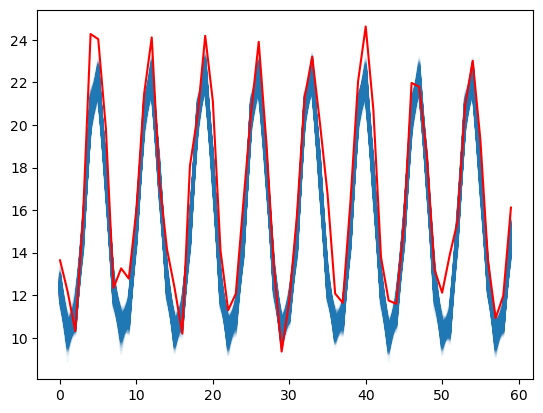

In [19]:
plt.plot(draws['predicted_counterfactual'][:, :, 2].T, color = 'C0', alpha = 0.05);
plt.plot(yt1[:, 2], color = 'red')

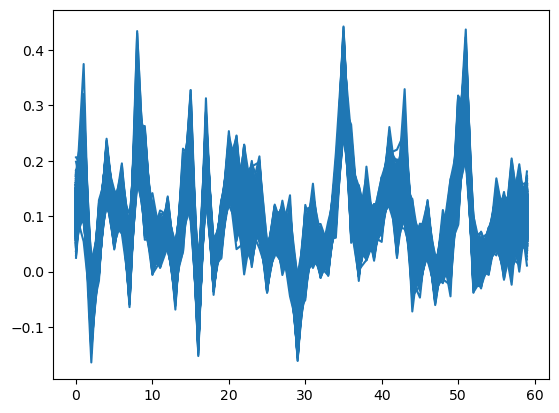

In [20]:
plt.plot(draws['estimated_lift'][:, :, 2].T, color = 'C0');


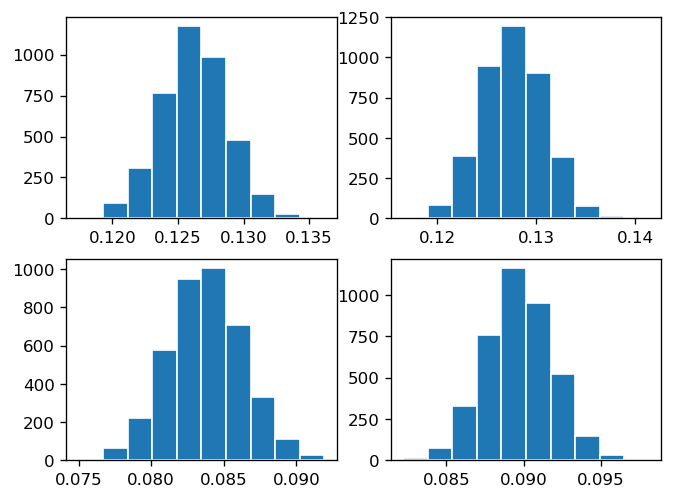

In [21]:
fig, ax = plt.subplots(dpi=120, ncols=2, nrows=2)

ax = ax.ravel()

for i, a in enumerate(ax):

    a.hist(draws['average_lift'][:, i].T, color = 'C0', edgecolor='white');


(array([7.000e+00, 4.900e+01, 2.530e+02, 6.720e+02, 1.188e+03, 1.052e+03,
        5.750e+02, 1.740e+02, 2.900e+01, 1.000e+00]),
 array([0.105265 , 0.1061357, 0.1070064, 0.1078771, 0.1087478, 0.1096185,
        0.1104892, 0.1113599, 0.1122306, 0.1131013, 0.113972 ]),
 <BarContainer object of 10 artists>)

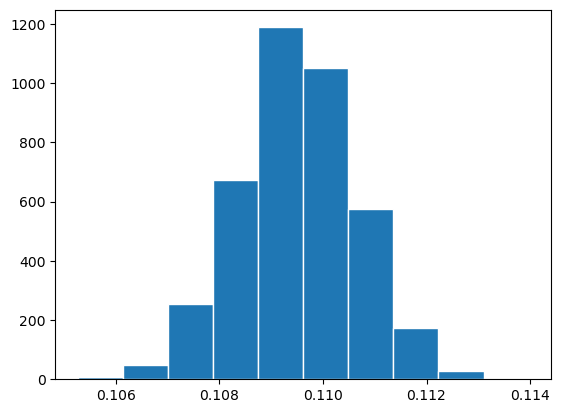

In [22]:
plt.hist(draws['total_lift'], edgecolor='white')

(array([   3.,   35.,  170.,  522., 1146., 1126.,  696.,  250.,   48.,
           4.]),
 array([0.105421 , 0.1063121, 0.1072032, 0.1080943, 0.1089854, 0.1098765,
        0.1107676, 0.1116587, 0.1125498, 0.1134409, 0.114332 ]),
 <BarContainer object of 10 artists>)

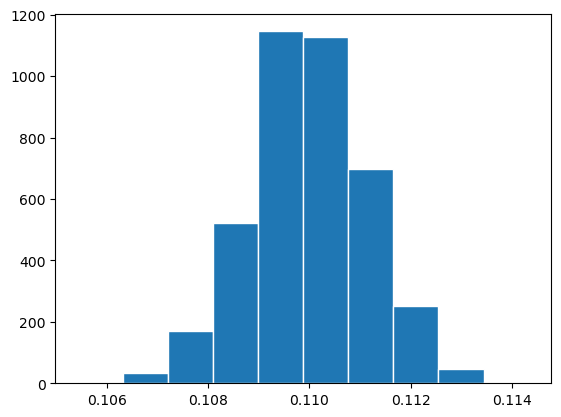

In [23]:
plt.hist(draws['naive_average_lift'], edgecolor='white')